<a href="https://www.kaggle.com/code/felipealuvino/potato-plant-disease-mask-approach-cnn-98?scriptVersionId=185272572" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')


2024-06-24 23:11:52.254674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 23:11:52.254778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 23:11:52.382809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **INTRODUCTION**

To analyze this dataset: 
* we first setup the trainning variables. 
* define some auxiliar functions to extract, metrics, get photos filter masks etc.
* observe the quality of the photos and their initial visual characteristics.
* define our model
* train out model

### **Setup trainning variables**

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3
N_CLASSES = 3

COLOR_BOUNDS = {
    'green': (np.array([35, 100, 100]), np.array([85, 255, 255])),
    'gray': (np.array([0, 0, 40]), np.array([180, 255, 70])),
    'black': (np.array([0, 0, 0]), np.array([180, 255, 30])),
    'brown': (np.array([10, 100, 20]), np.array([20, 255, 200])),
    'yellow': (np.array([20, 100, 100]), np.array([30, 255, 255])),
    'orange': (np.array([10, 100, 100]), np.array([25, 255, 255])),
    'red': (np.array([0, 100, 100]), np.array([10, 255, 255]))
}

categories = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

In [3]:
dataset_root_path = '/kaggle/input/potato-plant-diseases-data'
train_path = os.path.join(dataset_root_path, 'PlantVillage', 'PlantVillage')
test_path = os.path.join(dataset_root_path, 'PotatoPlants')
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Found 2152 images belonging to 3 classes.


## **AUXILIAR FUNCTIONS**

Below some auxiliar functions:


In [4]:
# Function to load images and masks
def load_images_and_masks(folder, label):
    images = []
    masks = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))  # Resize image
        masks.append(get_color_masks(img_rgb, COLOR_BOUNDS))
        images.append(img_rgb)
        labels.append(label)
    return images, masks, labels

# Function to get color masks
def get_color_masks(image):
    masks = []
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    for lower, upper in COLOR_BOUNDS.values():
        mask = cv2.inRange(hsv, lower, upper)
        masks.append(mask)
    return np.stack(masks, axis=-1)

# Function to show images
def show_images(generator, class_names, num_images=5):
    images, labels = next(generator)
    fig = plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_name = class_names[np.argmax(labels[i])]
        plt.title(f'{class_name}')
        plt.axis('off')
    plt.show()
    return images, labels, fig

# Function to show images and their histograms
def show_images_and_histograms(generator, class_names, num_images=5):
    images, labels = next(generator)
    fig, axes = plt.subplots(2, num_images, figsize=(15, 10))

    for i in range(min(num_images, len(images))):
        img = images[i]
        img_rgb = (img * 255).astype(np.uint8)
        class_name = class_names[np.argmax(labels[i])]

        # Display the image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'{class_name}')
        axes[0, i].axis('off')

        # Display the RGB histograms
        colors = ('r', 'g', 'b')
        for j, col in enumerate(colors):
            hist = cv2.calcHist([img_rgb], [j], None, [256], [0, 256])
            axes[1, i].plot(hist, color=col)
            axes[1, i].set_xlim([0, 256])

        axes[1, i].set_title(f'RGB Histogram ({class_name})')

    plt.tight_layout()
    plt.show()
    return images, labels, fig


# Function to show masks
def show_masks(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(len(COLOR_BOUNDS), num_images, figsize=(15, 15))
    for color_idx, (color, (lower, upper)) in enumerate(COLOR_BOUNDS.items()):
        for i in range(min(num_images, len(images))):
            img_rgb = (images[i] * 255).astype(np.uint8)
            img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
            mask = cv2.inRange(img_hsv, lower, upper)
            axes[color_idx, i].imshow(mask, cmap='gray')
            class_name = class_names[np.argmax(labels[i])]
            axes[color_idx, i].set_title(f'{color} Mask ({class_name})')
            axes[color_idx, i].axis('off')
    plt.tight_layout()
    return fig


# Function to plot color histograms
def plot_color_histograms(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 13))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(min(num_images, len(images))):
        img = (images[i] * 255).astype(np.uint8)
        class_name = class_names[np.argmax(labels[i])]
        color = ('b', 'g', 'r')
        plt.subplot(num_images, 1, i + 1)
        ax = axes[i]
        for k, col in enumerate(color):
            hist = cv2.calcHist([img], [k], None, [256], [0, 256])
            plt.plot(hist, color=col)
            plt.xlim([0, 256])
        plt.title(f'{class_name}')
        plt.show()


# Function to visualize predictions
def visualize_predictions(model, generator, class_names, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot((num_images // 5) + 1, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'True: {class_names[true_labels[i]]}', fontsize=8, pad=10)
        plt.xlabel(f'Predicted: {class_names[predicted_labels[i]]}', fontsize=8)
    plt.tight_layout()
    plt.show()
    
# Function to visualize predictions with confidence scores
def visualize_predictions_with_confidence(model, generator, class_names, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        plt.subplot((num_images // 5) + 1, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_class = class_names[true_labels[i]]
        predicted_class = class_names[predicted_labels[i]]
        confidence = confidence_scores[i]
        plt.title(f'True: {true_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}', fontsize=8, pad=10)
    plt.tight_layout()
    plt.show()

# Function to evaluate model and generate classification report and ROC curve
def evaluate_model(model, generator, class_names):
    y_true = []
    y_pred = []
    
    for i in range(len(generator)):
        images, labels = generator[i]
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
    
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    print(report_df)
    
    plt.figure(figsize=(8, 4))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_pred) == i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## **Visualization and explaning the filter colors criteria**

We found that certain colors, in addition to the standard RGB, could be useful as features in the modeling process. For instance:

* Orange: This color is significant as it can indicate early signs of disease, such as rust or decay on the plant leaves.
* Black: Often correspond to severe blight or necrosis, indicating advanced stages of disease.
* Yellow: Can indicate chlorosis or stress in the plants.
* Brown: Often point to lesions or spots caused by various plant diseases.
* Green: Different shades of green can help distinguish healthy parts of the plant from the affected ones.
* Gray: Might represent mold or other fungal growths.
* Red: Red spots can be indicative of specific types of fungal infections or other anomalies.

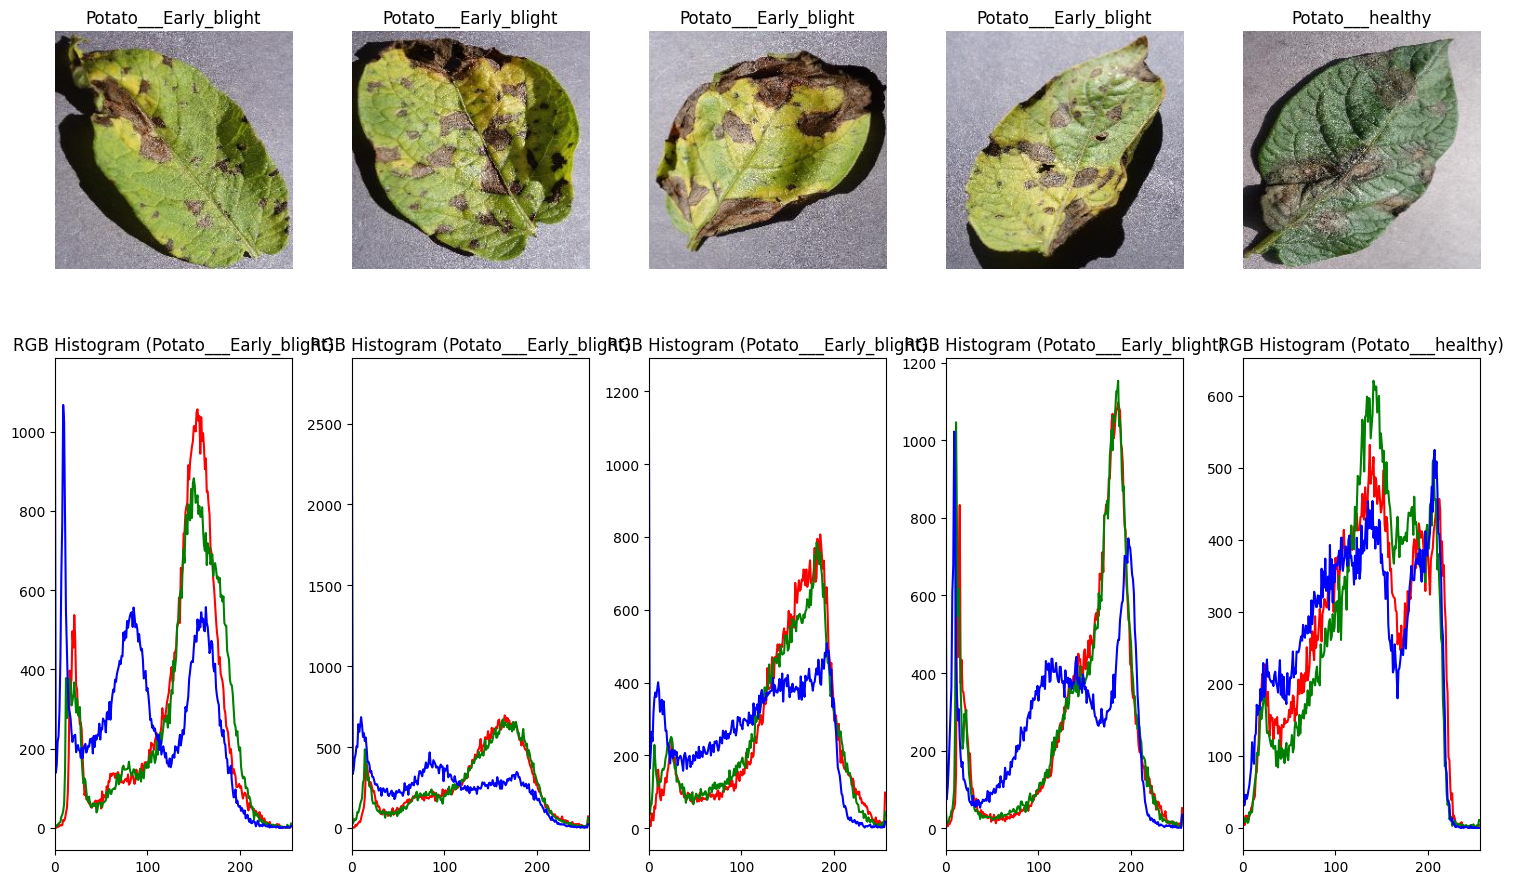

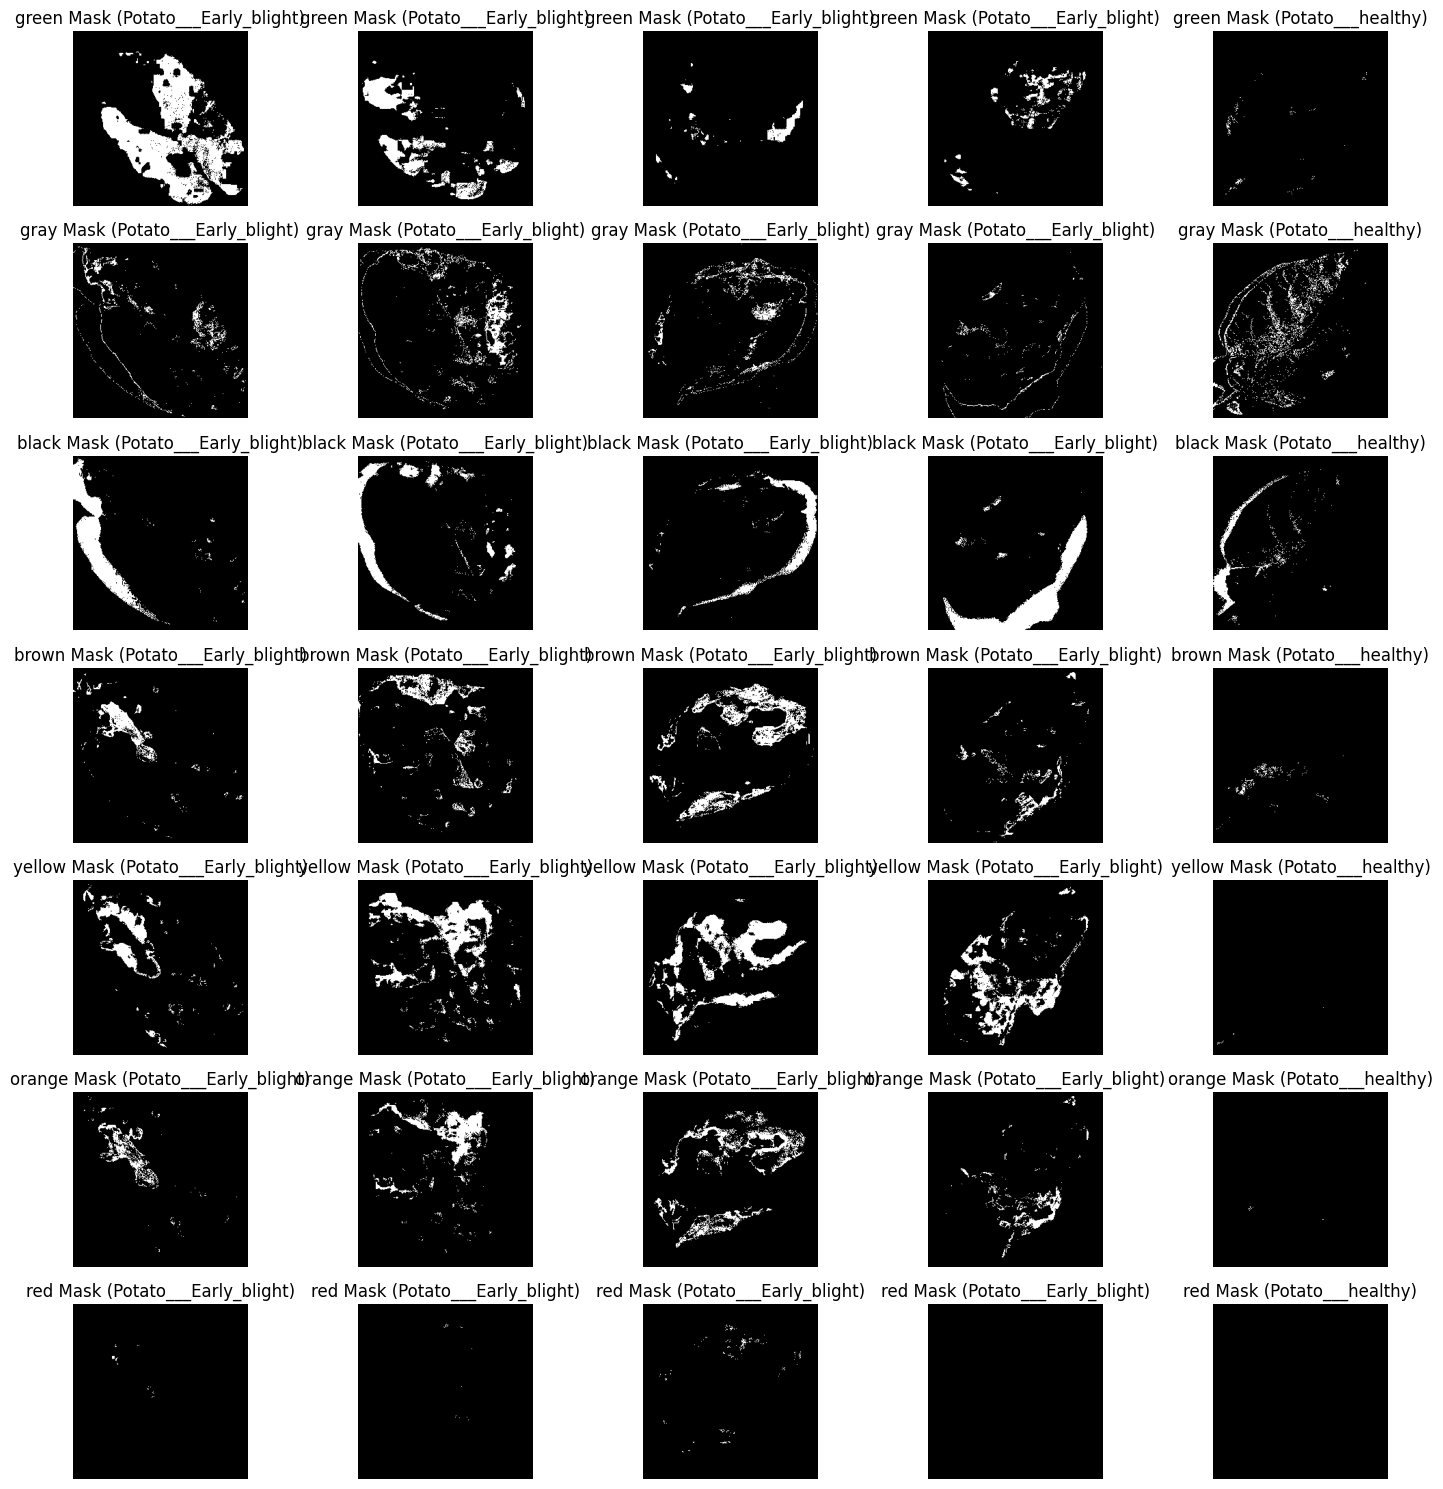

In [5]:
images, labels, fig1 = show_images_and_histograms(train_generator, categories, num_images=5)
fig1.savefig('images_and_histograms.png')

# Mostrar máscaras
fig2 = show_masks(images, labels, categories, num_images=5)
fig2.savefig('masks.png')


## **BUILDING THE CONVOLUTIONAL NEURAL NETWORK**

The following function `create_cnn_model` constructs and returns a Convolutional Neural Network (CNN) model using the `tensorflow.keras` library. This model is designed to perform classification tasks and includes various layers such as **batch normalization, dense layers, dropout layers**, and the softmax activation function in the output layer.

* **Batch Normalization:** Normalizes the input layer by adjusting and scaling the activations. This helps in stabilizing and accelerating the training process. Batch normalization layers normalize the output of the previous activation layer by subtracting the batch mean and dividing by the batch standard deviation, allowing for higher learning rates and faster convergence.

* **Flatten Layers:** Flattens the input, converting the multi-dimensional input into a single-dimensional vector. This is necessary before feeding the data into dense layers. For example, an input image of shape `{IMAGE_SIZE, IMAGE_SIZE, 3)` would be transformed into a vector of shape `(IMAGESIZE * IMAGESIZE * 3)`.

* **Dense Layer:** Fully connected layer with `n_nums neuron units` and ReLU (Rectified Linear Unit) activation function. This `layer learns n_nums features` from the input data. The ReLU activation function applies the non-linear transformation `f(x) = max(0, x)`.

* **Dropout:** Dropout layer with a rate of `rate%`. This layer randomly drops `rate%` of the units in the layer to prevent overfitting during training. Dropout works by randomly setting a fraction of input units to zero at each update during training time, which helps to prevent units from co-adapting too much.

* **Output Layer:** The output layer with `n_classes` units and softmax activation function. The softmax function is used for multi-class classification, converting the outputs to probabilities that sum to 1. Each unit represents the probability of one of the classes. The softmax activation function is defined as:
  $$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}} \quad \text{for } i = 1, \ldots, n$$
  where \(z\) is the input vector.


In [6]:
def create_cnn_model(input_shape, n_classes):

    model = models.Sequential()

    # model.add(conv_base)
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(264, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Dense layer with 64 units
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Dense layer with 4 units (output layer)
    # Input size: 64, Output size: 4
    model.add(Dense(3, activation='softmax'))


    return model

In [7]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = create_cnn_model(input_shape, N_CLASSES)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)




In [8]:
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test accuracy: {test_accuracy}')


# Save the model
model.save('plant_disease_model_final.keras')


Epoch 1/50
 1/54 ━━━━━━━━━━━━━━━━━━━━ 9:36 11s/step - accuracy: 0.3438 - loss: 1.7924

I0000 00:00:1719270743.861144      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719270743.877958      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/54 ━━━━━━━━━━━━━━━━━━━━ 32s 726ms/step - accuracy: 0.4669 - loss: 1.3071

W0000 00:00:1719270749.622528      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6132 - loss: 0.9584

W0000 00:00:1719270761.479756      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719270765.602112      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 419ms/step - accuracy: 0.6165 - loss: 0.9514 - val_accuracy: 0.4651 - val_loss: 3.3705
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8015 - loss: 0.5324 - val_accuracy: 0.4698 - val_loss: 1.4239
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8336 - loss: 0.4787 - val_accuracy: 0.6419 - val_loss: 0.7888
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8601 - loss: 0.4172 - val_accuracy: 0.7372 - val_loss: 0.5821
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8694 - loss: 0.3630 - val_accuracy: 0.8116 - val_loss: 0.4412
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8843 - loss: 0.3095 - val_accuracy: 0.8349 - val_loss: 0.3721
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8902 - loss: 0.3104 - val_accuracy: 0.8744 - val_loss: 0.3109
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8881 - loss: 0.3045 - val_accuracy: 0.8744 - val_loss: 

W0000 00:00:1719270905.125363      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy: 0.9828066825866699


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


W0000 00:00:1719270908.018271      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

W0000 00:00:1719270917.405805      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
                       precision    recall  f1-score      support
Potato___Early_blight   0.991984  0.990000  0.990991  1000.000000
Potato___healthy        0.971596  0.992000  0.981692  1000.000000
Potato___Late_blight    1.000000  0.875000  0.933333   152.000000
accuracy                0.982807  0.982807  0.982807     0.982807
macro avg               0.987860  0.952333  0.968672  2152.000000
weighted avg            0.983076  0.982807  0.982598  2152.000000


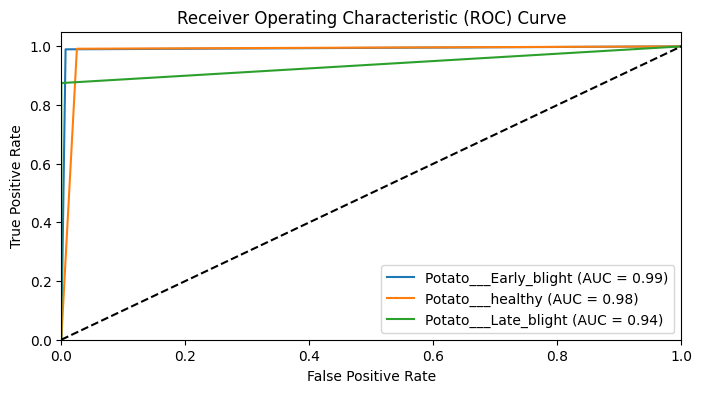

In [9]:
categories = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
# Evaluate the model with detailed metrics}
evaluate_model(model, test_generator, categories)


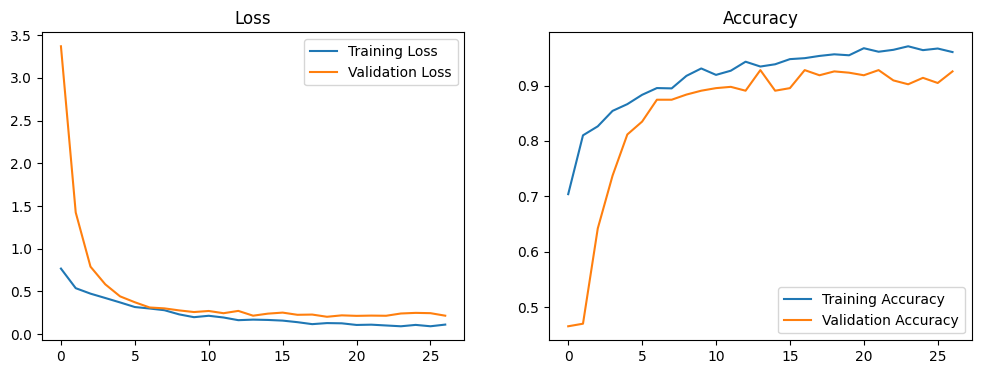

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


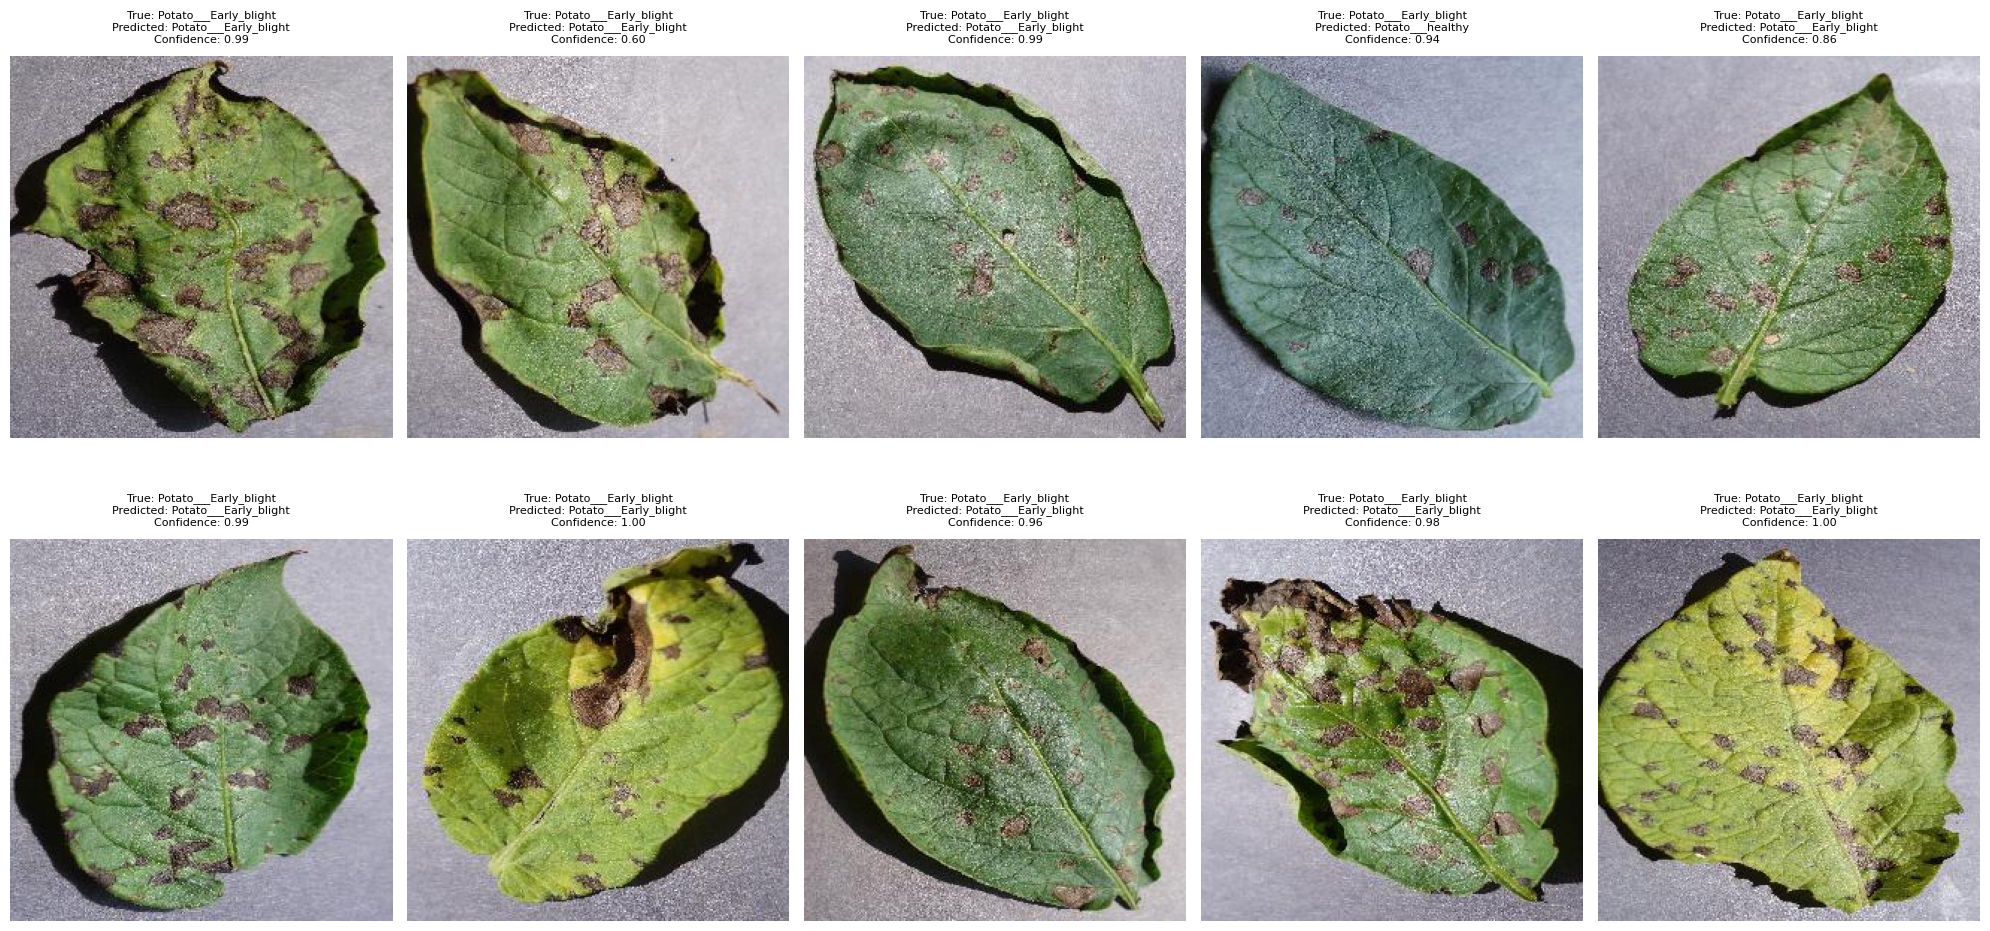

In [11]:
visualize_predictions_with_confidence(model, test_generator, categories, num_images=10)
